##### Notatki
Tutorial tutaj: https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

Dane Flickr 8k:
https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip


In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from statistics import mean

Using TensorFlow backend.


In [2]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "../../Flickr8k_text/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [3]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [4]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [5]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [6]:
descriptions['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [7]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [8]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [9]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [10]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [11]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions_en.txt')

In [12]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K) n testing dataset 5 times
train = []
test = []

for i in range(0,5):
    train.append(load_set(f'randomState/trainImages{i}.txt'))
    test.append(load_set(f'randomState/testImages{i}.txt'))

print('Dataset 1: %d' % len(train[0]))

Dataset 1: 700


In [13]:
# Below path contains all the images
images = '../../Flickr8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [14]:
# Below file conatains the names of images to be used in train data
train_images_file = '../../Flickr8k_text/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [15]:
# Below file conatains the names of images to be used in test data
test_images_file = '../../Flickr8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [16]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset, isForTraining):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			if isForTraining:
				desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			else:
				desc = ' '.join(image_desc)
			# store
			descriptions[image_id].append(desc)
	return descriptions


train_descriptions = []
test_descriptions = []
no_tokens_train_descriptions = []

# descriptions
for i in range(0,5):
    train_descriptions.append(load_clean_descriptions(f'descriptions_en.txt', train[i], True))
    print(f'Descriptions: train {i} = %d' % len(train_descriptions[i]))
    test_descriptions.append(load_clean_descriptions(f'descriptions_en.txt', test[i], False))
    print(f'Descriptions: test {i} = %d' % len(test_descriptions[i]))
    no_tokens_train_descriptions.append(load_clean_descriptions(f'descriptions_en.txt', train[i], False))
    print(f'Descriptions: train no tokens {i} = %d' % len(no_tokens_train_descriptions[i]))


Descriptions: train 0 = 700
Descriptions: test 0 = 300
Descriptions: train no tokens 0 = 700
Descriptions: train 1 = 700
Descriptions: test 1 = 300
Descriptions: train no tokens 1 = 700
Descriptions: train 2 = 700
Descriptions: test 2 = 300
Descriptions: train no tokens 2 = 700
Descriptions: train 3 = 700
Descriptions: test 3 = 300
Descriptions: train no tokens 3 = 700
Descriptions: train 4 = 700
Descriptions: test 4 = 300
Descriptions: train no tokens 4 = 700


In [17]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [18]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [19]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [20]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

###### Notatki
Poniższy kod zajmuje bardzo dużo czasu.

In [21]:
import os
import pickle


In [22]:
train_features = []

for i in range(0,5):
    train_features.append(load(open(f'Pickle/encoded_train_images_en_{i}.pkl', 'rb')))
    print(f'Photos: train {i} = %d' % len(train_features[i]))

Photos: train 0 = 700
Photos: train 1 = 700
Photos: train 2 = 700
Photos: train 3 = 700
Photos: train 4 = 700


In [23]:
# Create a list of all the training captions
all_train_captions = []

for i in range(0,5):
    all_train_captions.append([])
    for key, val in train_descriptions[i].items():
        for cap in val:
            all_train_captions[i].append(cap)
    print(len(all_train_captions[i]))

3500
3500
3500
3500
3500


In [24]:
# Call the funtion to encode all the test images - Execute this only once


In [25]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = []
vocab = []

for i in range(0,5):
    word_counts.append({})
    nsents = 0
    for sent in all_train_captions[i]:
        nsents += 1
        for w in sent.split(' '):
            word_counts[i][w] = word_counts[i].get(w, 0) + 1

    vocab.append([w for w in word_counts[i] if word_counts[i][w] >= word_count_threshold])
    print('preprocessed words %d -> %d' % (len(word_counts[i]), len(vocab[i])))

preprocessed words 2802 -> 438
preprocessed words 2767 -> 434
preprocessed words 2788 -> 453
preprocessed words 2720 -> 448
preprocessed words 2786 -> 444


In [26]:
ixtoword = []
wordtoix = []

for i in range(0,5):
    ixtoword.append({})
    wordtoix.append({})

    ix = 1
    for w in vocab[i]:
        wordtoix[i][w] = ix
        ixtoword[i][ix] = w
        ix += 1 

In [27]:
vocab_size = []

for i in range(0,5):
    vocab_size.append(len(ixtoword[i]) + 1) # one for appended 0's

vocab_size

[439, 435, 454, 449, 445]

In [28]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def get_max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

max_length = []

# determine the maximum sequence length
for i in range(0,5):
    max_length.append(get_max_length(train_descriptions[i]))
    print('Description Length: %d' % max_length[i])

Description Length: 30
Description Length: 30
Description Length: 30
Description Length: 30
Description Length: 30


Embedings pobrane stąd: https://www.kaggle.com/incorpes/glove6b200d

In [29]:
# Load Glove vectors
glove_dir = '../../glove'
embeddings_index = []

for i in range(0,5):
    embeddings_index.append({}) # empty dictionary

f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    coefs = np.asarray(values[1:], dtype='float32')
    for i in range(0,5):
        word = values[0]
        embeddings_index[i][word] = coefs

In [30]:
embedding_dim = 200
embedding_matrix = []
        
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
for i in range(0,5):
    embedding_matrix.append(np.zeros((vocab_size[i], embedding_dim)))

    for word, j in wordtoix[i].items():
        #if i < max_words:
        embedding_vector = embeddings_index[i].get(word)
        if embedding_vector is not None:
            # Words not found in the embedding index will be all zeros
            embedding_matrix[i][j] = embedding_vector

In [31]:
model = []

for i in range(0,5):
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    inputs2 = Input(shape=(max_length[i],))
    se1 = Embedding(vocab_size[i], embedding_dim, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size[i], activation='softmax')(decoder2)
    model.append(Model(inputs=[inputs1, inputs2], outputs=outputs))

In [32]:
for i in range(0,5):
    model[i].layers[2].set_weights([embedding_matrix[i]])
    model[i].layers[2].trainable = False

for i in range(0,5):
    model[i].compile(loss='categorical_crossentropy', optimizer='adam')
    
    
################### Tutaj załaduj wagi wyuczone w pliku Automatic Image Captioning-EN
for i in range(0,5):
    model[i].load_weights(f'model_weights/model_30_en_{i}.h5')

In [33]:
images = '../../Flickr8k_Dataset/'

Kolejny dość czasochłonny krok

In [34]:
encoding_train = []
encoding_test = []

#load image features from pickle files
for i in range(0,5):
    with open(f'Pickle/encoded_train_images_en_{i}.pkl', 'rb') as encoded_pickle:
        encoding_train.append(load(encoded_pickle))
    with open(f'Pickle/encoded_test_images_en_{i}.pkl', 'rb') as encoded_pickle:
        encoding_test.append(load(encoded_pickle))

In [35]:
def greedy_search(photo, index):
    in_text = 'startseq'
    for i in range(max_length[index]):
        sequence = [wordtoix[index][w] for w in in_text.split() if w in wordtoix[index]]
        sequence = pad_sequences([sequence], maxlen=max_length[index])
        yhat = model[index].predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[index][yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [37]:
#function for calculating cider metric
def cider(given_captions, prediction):
    prediction_arr = []
    prediction_arr.append(prediction)
    vectorizer = TfidfVectorizer()
    trainedV = vectorizer.fit(given_captions)
    givenTfIdf = trainedV.transform(given_captions).toarray()
    predTfIdf = trainedV.transform(prediction_arr).toarray()
    partialCiders = 0
    help_arr = []
    
    for c in givenTfIdf:
        help_arr.append(c)
        partialCiders = partialCiders + cosine_similarity(predTfIdf,help_arr)
        help_arr = []
        
    return partialCiders/len(givenTfIdf)

In [38]:
import warnings; warnings.simplefilter('ignore')
from IPython.display import clear_output

#preparation of metrics lists
bleu_train_scores = []
meteor_train_scores = []
cider_train_scores = []

bleu_test_scores = []    
meteor_test_scores = []
cider_test_scores = []
    
for i in range(0,5):
    bleu_train_scores.append([])
    meteor_train_scores.append([])
    cider_train_scores.append([])

    bleu_test_scores.append([])
    meteor_test_scores.append([])
    cider_test_scores.append([])
    
    train_pics = list(encoding_train[i].keys())
    test_pics = list(encoding_test[i].keys())

    #calculation of metrics for train images dataset
    for j in range(0,len(train_pics)):
        pic = train_pics[j]
        image = encoding_train[i][pic].reshape((1,2048))

        actual_desc_0 = no_tokens_train_descriptions[i][pic[:-4]][0]
        actual_desc_1 = no_tokens_train_descriptions[i][pic[:-4]][1]
        generated = greedy_search(image,i)
        bleu_train_scores[i].append(
            sentence_bleu(
                [actual_desc_0.split(), actual_desc_1.split()],
                generated.split())
        )
        meteor_train_scores[i].append(meteor_score(no_tokens_train_descriptions[i][pic.split('.')[0]],generated))
        cider_train_scores[i].append(cider(no_tokens_train_descriptions[i][pic.split('.')[0]],generated)[0][0])

        clear_output(wait=True)
        print('train',i,j, flush=True)

    #calculation of metrics for test images dataset
    for j in range(0,len(test_pics)):
        pic = test_pics[j]
        image = encoding_test[i][pic].reshape((1,2048))

        actual_desc_0 = test_descriptions[i][pic[:-4]][0]
        actual_desc_1 = test_descriptions[i][pic[:-4]][1]
        generated = greedy_search(image,i)
        bleu_test_scores[i].append(
            sentence_bleu(
                [actual_desc_0.split(), actual_desc_1.split()],
                generated.split())
        )
        meteor_test_scores[i].append(meteor_score(test_descriptions[i][pic.split('.')[0]],generated))
        cider_test_scores[i].append(cider(test_descriptions[i][pic.split('.')[0]],generated)[0][0])

        clear_output(wait=True)
        print('test',i,j, flush=True)


result_data = {}

#calculate mean score based on socres list for each metric
for i in range(0,5):
    result_data[str(i)] = [
        mean(bleu_train_scores[i]),
        mean(bleu_test_scores[i]),
        mean(meteor_train_scores[i]),
        mean(meteor_test_scores[i]),
        mean(cider_train_scores[i]),
        mean(cider_test_scores[i])
    ]

result = pd.DataFrame.from_dict(
    result_data,
    orient='index',
    columns=['Bleu TREN', 'Bleu TEST', 'Meteor TREN', 'Meteor TEST', 'CIDEr TREN', 'CIDEr TEST']
)

result

test 4 299


,Bleu TREN,Bleu TEST,Meteor TREN,Meteor TEST,CIDEr TREN,CIDEr TEST
0,0.040223,0.006174,0.377538,0.200344,0.274116,0.208447
1,0.029962,0.001219,0.346118,0.182729,0.269415,0.194796
2,0.046277,0.001125,0.375097,0.203053,0.271186,0.200586
3,0.046673,0.003195,0.375640,0.190875,0.271599,0.190957
4,0.042322,0.001075,0.365569,0.183848,0.270863,0.193765


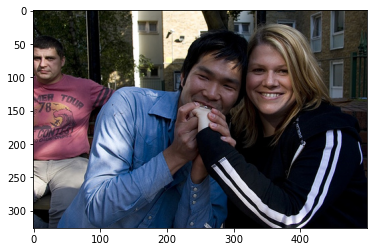

Test 0 : girl with pink shirt and red shirt is on
Meteor score:  0.08547008547008547
Cider score:  0.1341634108270941


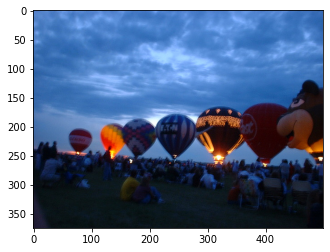

Test 1 : black and white dog with baseball in mouth outdoor
Meteor score:  0.05555555555555555
Cider score:  0.08345427883705059


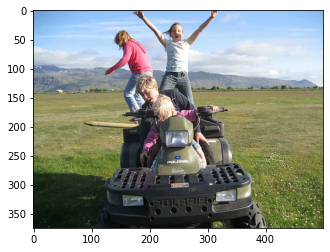

Test 2 : man is on his chair
Meteor score:  0.07352941176470587
Cider score:  0.22031358735980935


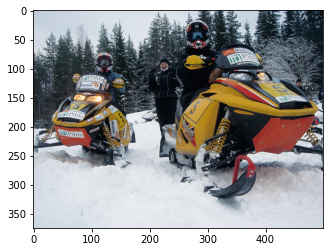

Test 3 : man wearing red jacket is riding red red sled
Meteor score:  0.16666666666666666
Cider score:  0.14281237750118564


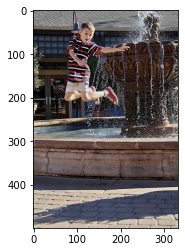

Test 4 : there is man in white shirt and pink sweater is on chair next to tree
Meteor score:  0.13157894736842105
Cider score:  0.2969568221480794


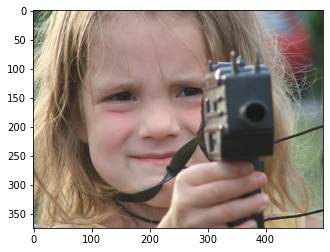

Test 5 : young girl wearing big bathing suit and jeans stand in the grass
Meteor score:  0.25
Cider score:  0.19921989747583943


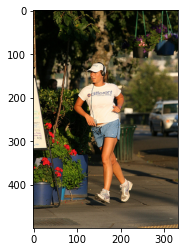

Test 6 : young girl in pink bathing suit jumps up on her head in the air
Meteor score:  0.10526315789473684
Cider score:  0.21378820398937953


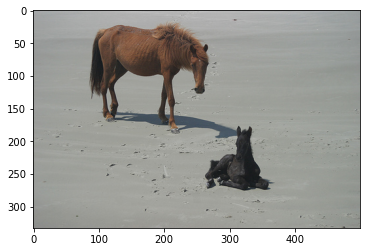

Test 7 : the is his to the ground
Meteor score:  0.22417153996101363
Cider score:  0.2106987695589905


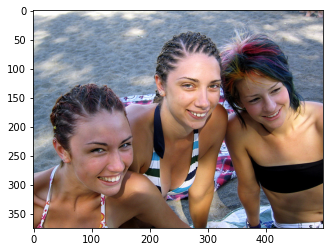

Test 8 : girl in dress and black shirt and goggles laying on the back of the water
Meteor score:  0.32877604166666663
Cider score:  0.34577783704733384


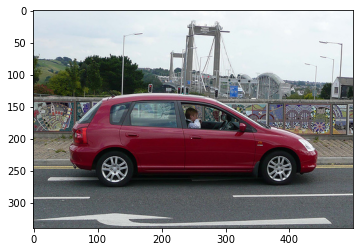

Test 9 : man is sitting on of sidewalk holding red
Meteor score:  0.10204081632653061
Cider score:  0.15791453970842387


In [40]:
#caption generation
model_num = 4

pics = list(encoding_test[model_num].keys())


#for i in range(0,len(pics)):
for i in range(0,10):
    pic = pics[i]
    image = encoding_test[model_num][pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    caption = generated = greedy_search(image,model_num)
    
    
    print("Test",i,":",caption)
    print("Meteor score: ", meteor_score(test_descriptions[model_num][pic.split('.')[0]],generated))
    print("Cider score: ", cider(test_descriptions[model_num][pic.split('.')[0]],generated)[0][0])